# Welcome to AMPLab!

Hi, this is a practice project for you to get familiar with deriving click-evoked auditory brainstem response (ABR) using python from raw EEG data.

We will go through the analysis step-by-step.

## Set up Python3 environment

1. Download Anaconda3
2. Choose your IDE (e.g., Spyder, VScode, PyCharm, etc).
3. Install basic packages including: 
  - Signal processing: `numpy`, `scipy`
  - Data visualization: `matplotlib`
  - EEG signal processing: [`mne`](https://mne.tools/stable/install/index.html)
  - (may or maynot be needed in the analysis) Audio-visual experiment package: [`expyfun`](https://https://github.com/LABSN/expyfun/blob/main/doc/getting_started.rst)
  
  p.s. The last two may require some dependencies.

An example for setting up the environment called `expy` in ananconda prompt:

In [1]:
# conda create -n expy python=3 numpy scipy matplotlib pandas h5py joblib pillow
# conda activate expy
# pip install mne "pyglet<1.6" pyparallel rtmixer
# pip install git+https://github.com/labsn/expyfun

In [2]:
! conda activate expy
import numpy as np
import scipy.signal as signal
from numpy.fft import fft, ifft
import matplotlib.pyplot as plt
from expyfun.io import read_wav, write_hdf5
import mne

# Dataset description
## Click waveform dataset
Clicks are generated from Poisson process with a rate of **40/s**. There are ten trials of click data that are presented, each contains **1-min long** clicks.


Source: `/click_waveform_datast`

The dataset includes click trial from click000.wav to click009.wav, which are presented in order.

 The sampling frequency of the waveform is **48000 Hz**.
## EEG dataset
Source: `/click_EEG_dataset`

Dataset for subject from "subejcts001" to "subject024", (excluding "subject014" and "subject021" because of bad quality)

For this particular EEG dataset, the data format is `.fif` (e.g., subject001_click_eeg.fif). However, the raw dataset from BrainVision will include three files: `.eeg`, `.vmrk` and `.vhdr`.

There are two channels in the dataset `['EP1','EP2']`.
The sampling frequency of the EEG data is **10000 Hz**.

In [3]:
# %% Parameters
# EEG param
eeg_fs = 10000 # EEG sampling frequency
# Stim param
rate = 40 # click rate
t_click = 60 # click waveform length in second
stim_fs = 48000 # click waveform sampling frequency
n_epoch_click = 10 # number of click epochs

## Load EEG data
Use `mne.io.read_raw_fif()` for `.fif` format file.

For brainvision data, use `mne.io.read_raw_brainvision()`, and the argument should be the `.vhdr` pathway. Note, your `.eeg`, `.vhdr` and `.vmrk` files should be in the same folder directory.

Let's derive ABR from `subject001` as a start point.

In [4]:
subject = 'subject001'
# locate the directory of EEG file
eeg_path = "C:/Users/Administrator/Documents/ClickABR/ClickABR/click_EEG_dataset/" + subject + '_click_eeg.fif'
# Read raw file
eeg_raw = mne.io.read_raw_fif(eeg_path, preload=True)

Opening raw data file C:/Users/Administrator/Documents/ClickABR/ClickABR/click_EEG_dataset/subject001_click_eeg.fif...
Isotrak not found
    Range : 0 ... 6590000 =      0.000 ...   659.000 secs
Ready.
Reading 0 ... 6590000  =      0.000 ...   659.000 secs...


## Preprocessing
[`scipy`](https://scipy.org/) is used for filtering.

1. High-pass the EEG at 0.1 Hz (or 1 Hz) to filter out slow drifts.
2. Notch filter at 60, 180, and 540 Hz to filter out power line noise. The three frequencies used here is for this specific EEG dataset. For your own data, you can use `eeg_raw.compute_psd().plot()` function to plot the psd of the raw EEG, and it is easy to spot the noise.

In [5]:
# Define IIR High pass Filter function
def butter_highpass(cutoff, fs, order=1):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=1):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = signal.lfilter(b, a, data)
    return y

# High pass at 1 Hz
eeg_f_hp = 1.
eeg_raw._data = butter_highpass_filter(eeg_raw._data, eeg_f_hp, eeg_fs)

Let's see which power line noise frequencies are there

Effective window size : 0.205 (s)


C:\Users\Administrator\AppData\Local\Temp\ipykernel_2812\3958028539.py:2: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  eeg_raw.compute_psd().plot(show=False)


<Figure size 640x480 with 0 Axes>

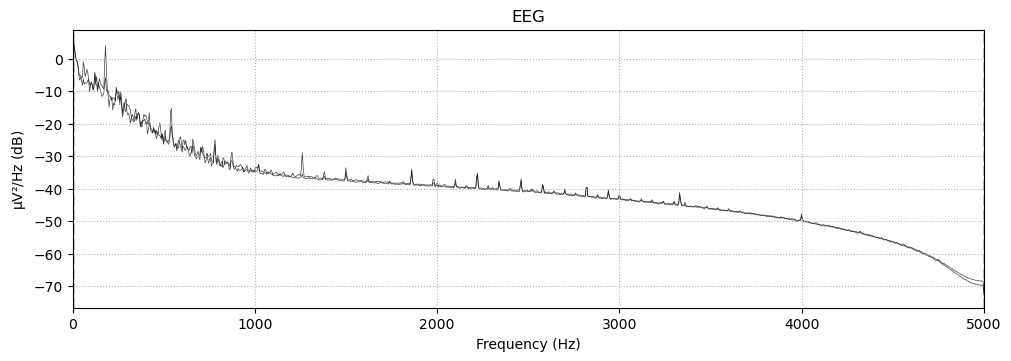

In [6]:
plt.figure()
eeg_raw.compute_psd().plot(show=False)
plt.show()

Apply notch filter at 60, 180 and 540 Hz

In [7]:
# Notch filter 
notch_freq = [60, 180, 540]
notch_width = 5
for nf in notch_freq:
    bn, an = signal.iirnotch(nf / (eeg_fs / 2.), float(nf) / notch_width)
    eeg_raw._data = signal.lfilter(bn, an, eeg_raw._data)

Let's see the psd again. The main powerline noise below 1000 Hz (frequency range of interests for most ABRs) are removed.

Effective window size : 0.205 (s)


C:\Users\Administrator\AppData\Local\Temp\ipykernel_2812\3958028539.py:2: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  eeg_raw.compute_psd().plot(show=False)


<Figure size 640x480 with 0 Axes>

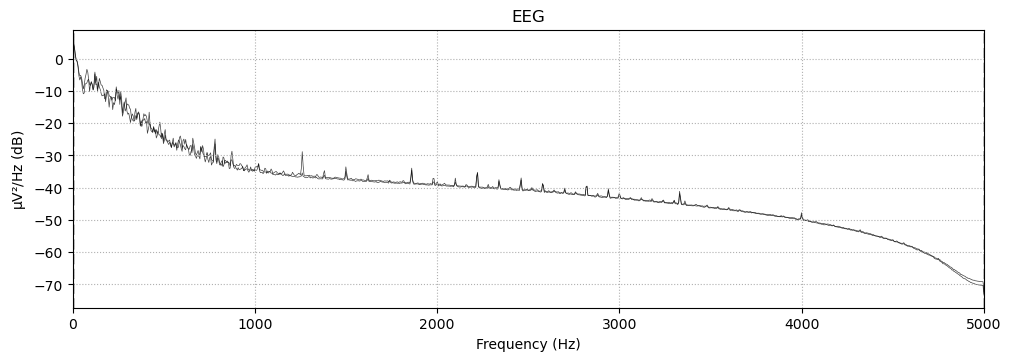

In [8]:
plt.figure()
eeg_raw.compute_psd().plot(show=False)
plt.show()

## Epoching
Epoching is used to extract chunks of EEG signal that time-locked to your stimulus. For this dataset, we need to extract the 10 epochs of 1-min long click trials. Every epoch is annotated with the trigger marker time stamped at the beginning. For this data, it is marked with a '1' followed by a 10-digit '4's and '8's which is coded by the stimulus type and trial number. They are coded accoding to this function:
```python
trigger = [(b + 1) * 4 for b in decimals_to_binary([0, cn], [n_bits_type,       n_bits_epoch])]
```

For example, click is type 0, and for `click009.wav` trial, the binary code is `[0, 0, 0, 0, 0, 0, 1, 0, 0, 1]`, then is converted to trigger `[4, 4, 4, 4, 4, 4, 8, 4, 4, 8]`.

Since the clicks trials are presented in order here, we don't need to worry about this coding too much. But it is useful for randomized trials.

Use `mne.events_from_annotations()` to get the trigger list, and then use `mne.Epochs()` to get the click epochs data.

In [9]:
# Get annotated events list
events, event_dict = mne.events_from_annotations(eeg_raw)
# Using the trigger time stamp for trial onset to extract each click epoch
epochs_click = mne.Epochs(eeg_raw, events, tmin=0,
                            tmax=(t_click - 1/stim_fs + 1),
                            event_id=1, baseline=None,
                            preload=True, proj=False)
# 
epoch_click = epochs_click.get_data()

Non-RawBrainVision raw using branvision markers


Used Annotations descriptions: ['New Segment/', 'Stimulus/S  1', 'Stimulus/S  2', 'Stimulus/S  4', 'Stimulus/S  8']
Not setting metadata
11 matching events found
No baseline correction applied
Using data from preloaded Raw for 11 events and 610001 original time points ...
1 bad epochs dropped


C:\Users\Administrator\AppData\Local\Temp\ipykernel_2812\3763643264.py:9: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epoch_click = epochs_click.get_data()


# Analysis
## Convert click waveforms to pulse trains
To do the cross-correlation, we need to convert the click waveforms to a pulse train.
1. Read the click waveform files. You can do it with `expyfun.io.read_wav()`.
2. Rectify the waveform by getting the absolute value.
3. Identify the time point when the waveform has a click happen, and mark that time point with a pulse (a number '1' in the sequence).

Note, the output pulse train should match the sampling frequency of EEG data in order to do the cross-correlation.

In [10]:
# Change to your own click waveform path
file_path = "C:/Users/Administrator/Documents/ClickABR/ClickABR/click_waveform_data/"
# Converting click waveform to event pulse train
x_in = np.zeros((n_epoch_click, int(t_click * eeg_fs)), dtype=float)
for ei in range(n_epoch_click):
    stim, fs_stim = read_wav(file_path + 'click{0:03d}'.format(ei) + '.wav', verbose=False)
    stim_abs = np.abs(stim)
    click_times = [(np.where(np.diff(s) > 0)[0] + 1) / float(fs_stim) for s in stim_abs]
    click_inds = [(ct * eeg_fs).astype(int) for ct in click_times]
    x_in[ei, click_inds] = 1

Let's see what the click pulse train looks like

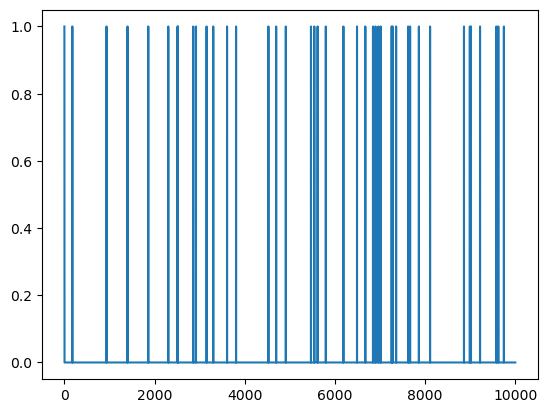

In [11]:
# Plot click pulse train
# showing the first 1 s in the first trial pulse train
plt.figure()
plt.plot(x_in[0, 0:int(eeg_fs)]) 
plt.show()

Make the epoch in a format `x_out` that share the same shape as `x_in`, preparing for the following analysis

In [12]:
# Make the epoch as x_out in a format used in following ananlysis
len_eeg = int(eeg_fs * t_click)
x_out = np.zeros((n_epoch_click, 2, len_eeg))
for i in range(n_epoch_click):
    x_out[i, :, :] = epoch_click[i, :, 0:int(eeg_fs*t_click)]
x_out = np.mean(x_out, axis=1) # take the average of the two channels

## Fourier Transform
We usually complete the cross-correlation in frequency domain. (You could also do it in time domain, but frequency domain multiplication is more efficient.)

There are originally two channels of EEG data, average the two channels first.

Use `numpy.fft.fft()` for fast fourier transform of EEG and click pulse train.

## Cross-Correlation in Frequency Domain
The cross-correlation in time domain is equivalent to the multiplication of FFT(EEG) and the conjugate of FFT(pulse_train) in frequency domain. Remember, we still need the ABR result to be in time domain, so use `numpy.fft.ifft()` to inverse the fourier transform. 

In [13]:
# Do fft
x_in_fft = fft(x_in, axis=-1)
x_out_fft = fft(x_out, axis=-1)
# Get cross-correlation
cc = np.real(ifft(x_out_fft * np.conj(x_in_fft)))

## Get the Averaged Click ABR
We now have the click-evoked ABR for each trial. But what we need is the averaged ABR for that subject. Therefore, we need take the mean of the 10 trials. 

The ABR we get is the sum of click ABR through the trial, which is actually (40 clicks/s * 60 s) times the ABR for a single click. So we then need to devide the amplitude of the ABR by (40*60).

Since the derived ABR is circular, we can concatenate the last 200 ms and the first 600 ms to get a typical auditory evoked potential (AEP). To show the click-evoked ABR, we usually plot the time range [-10, 30] ms. 

In [14]:
# take the averaged cc across epochs
abr = np.mean(cc, axis=0)
# rearange the ABR from -200 to 600 ms
t_start, t_stop = -200e-3, 600e-3  # define ABR lag range, from -200 ms to 600 ms
abr_response = np.concatenate((abr[int(t_start*eeg_fs):], abr[0:int(t_stop*eeg_fs)])) / (rate*t_click)

## Plot ABR

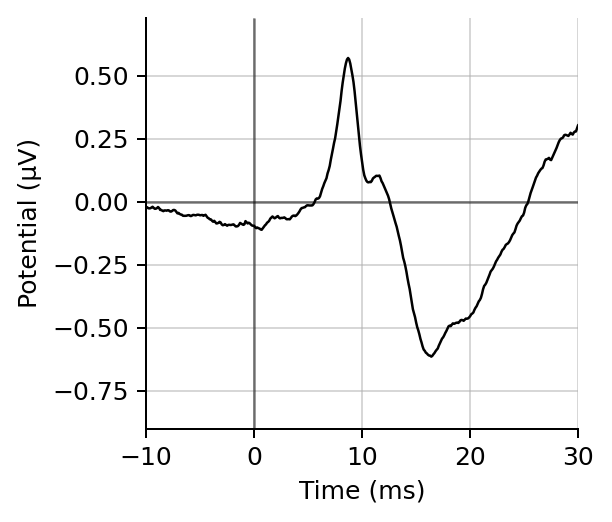

In [15]:
# Define the time vector
lags = np.arange(start=t_start*1000, stop=t_stop*1000, step=1e3/eeg_fs) # time vector in unit 'ms'
# Plot
fig = plt.figure(dpi=180)
fig.set_size_inches(3.5, 3)
plt.plot(lags, abr_response*1e6, c='k', linewidth=1, label='Click')
plt.xlim(-10, 30)
plt.ylim(-0.9,0.73)
plt.ylabel('Potential (μV)')
plt.xlabel('Time (ms)')
plt.grid(alpha=0.5)
plt.vlines(0,-0.9,0.73, linestyles='solid', color='k', linewidth=1, alpha=0.5)
plt.hlines(0,-10,30, linestyles='solid', color='k', linewidth=1, alpha=0.5)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig('click_fig.png', format='png')
plt.show()